In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import os

# Load the DataFrame
df = pd.read_csv('/kaggle/input/metadata-filled-86-5/filledValues_0.8652173913043478.csv', index_col=0, low_memory=False)

# Define the path to the images directory
image_directory = '/kaggle/input/hair-removed-pad-ufes/hair_removed_pad_ufes'  # Update with your actual image directory path

# Function to load, resize, and convert images to numpy arrays
def load_resize_and_convert_image(img_id, size=(224, 224)):
    try:
        # Construct the full image path (adjust extension if necessary)
        image_path = os.path.join(image_directory, f"{img_id}")  # Adjust the extension as needed
        # Open the image
        image = Image.open(image_path)
        # Convert the image to RGB (if necessary)
        image = image.convert("RGB")
        # Resize the image
        image = image.resize(size)  # No need to specify ANTIALIAS
        # Convert the image to a numpy array and normalize it
        image_array = np.array(image) # Normalize pixel values to [0, 1]
        return image_array
    except Exception as e:
        print(f"Error loading image {img_id}: {e}")
        return None  # Return None if there was an error

# Create a new column 'image' and load images as numpy arrays
df['image'] = df['img_id'].apply(load_resize_and_convert_image)

# Remove specified columns from the DataFrame
columns_to_remove = ['patient_id', 'lesion_id', 'img_id']
df.drop(columns=columns_to_remove, inplace=True, errors='ignore')

# Display the first few rows of the updated DataFrame
df.head()

,smoke,drink,background_father,background_mother,age,pesticide,gender,skin_cancer_history,cancer_history,has_piped_water,...,diameter_2,diagnostic,itch,grew,hurt,changed,bleed,elevation,biopsed,image
0,False,True,SPAIN,PORTUGAL,8,True,FEMALE,True,True,False,...,0,NEV,False,False,False,False,False,False,False,"[[[148, 100, 56], [148, 100, 56], [148, 100, 5..."
1,False,False,POMERANIA,POMERANIA,55,False,FEMALE,True,True,True,...,5,BCC,True,True,False,True,True,True,True,"[[[173, 141, 138], [171, 141, 138], [175, 145,..."
2,True,False,BRAZIL,PORTUGAL,77,True,MALE,True,True,True,...,1,ACK,True,False,False,False,False,False,False,"[[[212, 142, 138], [220, 152, 148], [218, 151,..."
3,True,False,BRAZIL,PORTUGAL,75,True,MALE,True,True,True,...,1,ACK,True,False,False,False,False,False,False,"[[[182, 171, 174], [183, 174, 177], [185, 179,..."
4,False,True,POMERANIA,POMERANIA,79,False,MALE,True,False,False,...,5,BCC,True,True,False,False,True,True,True,"[[[115, 82, 70], [109, 76, 64], [110, 77, 65],..."


In [2]:
SIZE=224    ### 64, 72, 80
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(df['diagnostic'])

label_to_dx_mapping = {label: dx for label, dx in zip(le.transform(le.classes_), le.classes_)}

print(list(le.classes_))

df['diagnostic'] = le.transform(df["diagnostic"])

print(df.sample(10))
print(label_to_dx_mapping)
### maximize the size of image or find optimal size (whether to increase it or decrease it) to get best acc   64 acc:   higher acc:  

['ACK', 'BCC', 'MEL', 'NEV', 'SCC', 'SEK']
      smoke  drink background_father background_mother  age  pesticide  \
1684  False   True           GERMANY          PORTUGAL   49      False   
1803  False  False           GERMANY           GERMANY   44      False   
1870   True  False            BRAZIL          PORTUGAL   68       True   
2224  False  False           GERMANY             ITALY   54      False   
2060   True  False            BRAZIL          PORTUGAL   70       True   
1352  False  False             SPAIN          PORTUGAL   64       True   
1712   True  False            BRAZIL            BRAZIL   73      False   
1251  False   True            BRAZIL            BRAZIL   37       True   
1334  False   True           AUSTRIA          PORTUGAL   37       True   
1030   True  False            BRAZIL          PORTUGAL   42       True   

      gender  skin_cancer_history  cancer_history  has_piped_water  ...  \
1684    MALE                False            True            False 

2024-11-06 08:40:27.821747: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-06 08:40:27.821847: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-06 08:40:27.956230: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


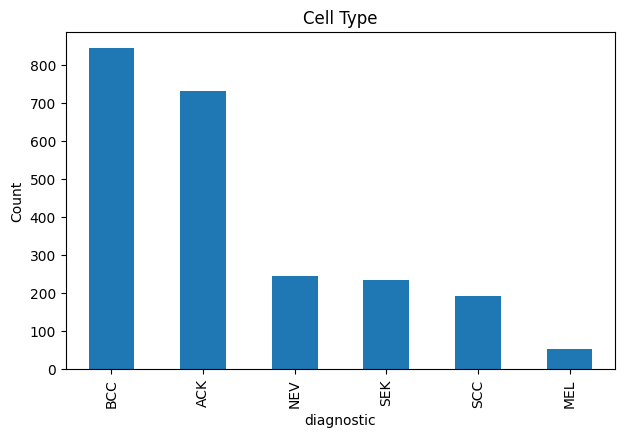

diagnostic
1    845
0    730
3    244
5    235
4    192
2     52
Name: count, dtype: int64


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(42)
from sklearn.metrics import confusion_matrix
import keras
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
import cv2
import random
import imgaug.augmenters as iaa
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import models, layers, optimizers
# Suppress warnings

fig = plt.figure(figsize=(12, 8))

ax1 = fig.add_subplot(221)
df['diagnostic'].map(label_to_dx_mapping).value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Cell Type')

plt.tight_layout()
plt.show()
# Distribution of data into various classes 
print(df['diagnostic'].value_counts())

1517


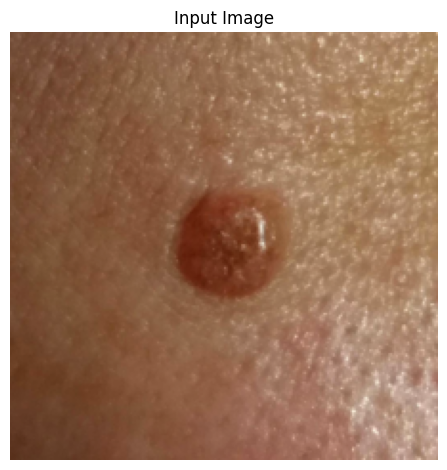

In [4]:
random_index = random.choice(df.index)
print(random_index)
image = df.loc[random_index, 'image']
plt.imshow(image)
plt.title('Input Image')
plt.axis('off')
plt.tight_layout()
plt.show()

In [5]:
from sklearn.model_selection import train_test_split

# Perform stratified train-test split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['diagnostic'])

# Display the number of samples in each set
print("Training set size:", len(train_df))
print("Test set size:", len(test_df))

# Optional: Check the distribution of 'diagnostic' in both sets to ensure stratification
print("Training set distribution:\n", train_df['diagnostic'].value_counts(normalize=True))
print("Test set distribution:\n", test_df['diagnostic'].value_counts(normalize=True))

Training set size: 1838
Test set size: 460
Training set distribution:
 diagnostic
1    0.367791
0    0.317737
3    0.106094
5    0.102285
4    0.083243
2    0.022851
Name: proportion, dtype: float64
Test set distribution:
 diagnostic
1    0.367391
0    0.317391
3    0.106522
5    0.102174
4    0.084783
2    0.021739
Name: proportion, dtype: float64


In [6]:
train_df_meta = train_df.copy()
test_df_meta = test_df.copy()
print(train_df_meta)

      smoke  drink background_father background_mother  age  pesticide  \
728   False  False         POMERANIA         POMERANIA   68       True   
1653   True  False            BRAZIL          PORTUGAL   53       True   
2186  False   True         POMERANIA         POMERANIA   51       True   
127    True  False            BRAZIL          PORTUGAL   40       True   
903   False  False           GERMANY           GERMANY   64      False   
...     ...    ...               ...               ...  ...        ...   
1671  False   True             ITALY            POLAND   61      False   
1169   True  False           AUSTRIA         POMERANIA   66       True   
461   False   True         POMERANIA         POMERANIA   72       True   
456   False   True           GERMANY           GERMANY   59       True   
747   False  False         POMERANIA         POMERANIA   53      False   

      gender  skin_cancer_history  cancer_history  has_piped_water  ...  \
728     MALE                False   

In [7]:
train_df = train_df[['image', 'diagnostic']]
test_df = test_df[['image', 'diagnostic']]

print(train_df)
print(test_df)

                                                  image  diagnostic
728   [[[134, 103, 83], [133, 102, 82], [128, 98, 78...           0
1653  [[[76, 63, 48], [79, 66, 49], [83, 72, 53], [8...           0
2186  [[[175, 154, 140], [174, 152, 135], [173, 151,...           1
127   [[[138, 97, 72], [138, 97, 72], [139, 95, 71],...           0
903   [[[241, 175, 155], [239, 174, 153], [237, 173,...           5
...                                                 ...         ...
1671  [[[172, 131, 121], [168, 128, 118], [167, 129,...           1
1169  [[[84, 86, 83], [81, 82, 78], [71, 71, 67], [5...           0
461   [[[101, 70, 71], [109, 80, 79], [137, 107, 107...           1
456   [[[166, 157, 142], [167, 159, 143], [171, 165,...           1
747   [[[63, 44, 38], [61, 40, 36], [56, 36, 31], [5...           1

[1838 rows x 2 columns]
                                                  image  diagnostic
11    [[[164, 133, 137], [164, 133, 137], [161, 130,...           1
719   [[[209, 169, 135]

In [8]:
from sklearn.utils import class_weight
import numpy as np

# Calculate class weights
class_weights = class_weight.compute_sample_weight(class_weight='balanced',
                                                   y=train_df['diagnostic'])

# Create a dictionary mapping class labels to their weights
class_weights_dict = {label: weight for label, weight in zip(train_df['diagnostic'], class_weights)}

print(class_weights_dict)

{0: 0.5245433789954338, 1: 0.4531558185404339, 5: 1.6294326241134751, 4: 2.002178649237473, 3: 1.570940170940171, 2: 7.2936507936507935}


diagnostic
1    676
0    584
3    195
5    188
4    153
2     42
Name: count, dtype: int64
676
diagnostic
1    324
0    416
3    805
5    812
4    847
2    958
Name: count, dtype: int64


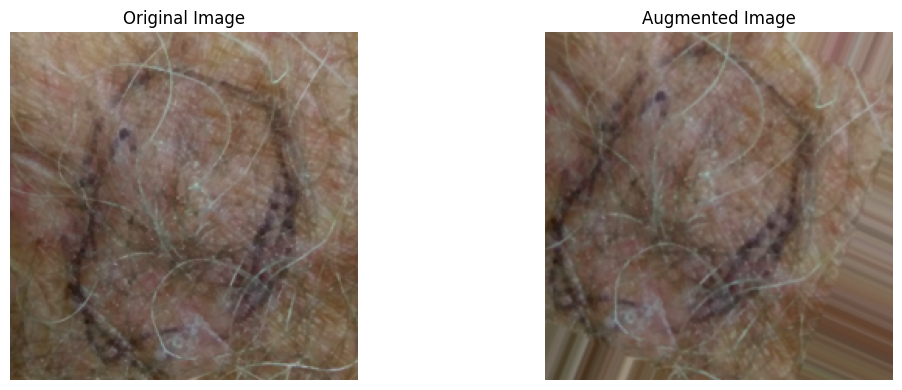

                                                  image diagnostic
0     [[[150, 141, 133], [150, 140, 132], [149, 139,...          1
1     [[[178, 155, 127], [177, 150, 124], [180, 150,...          5
2     [[[126, 80, 47], [128, 80, 47], [131, 80, 48],...          4
3     [[[157, 133, 141], [156, 133, 140], [157, 131,...          2
4     [[[36, 26, 23], [37, 28, 25], [38, 28, 25], [4...          4
...                                                 ...        ...
5995  [[[184, 133, 116], [181, 130, 113], [177, 127,...          1
5996  [[[225, 191, 176], [226, 192, 177], [226, 192,...          3
5997  [[[210, 180, 188], [211, 182, 188], [211, 184,...          0
5998  [[[123, 65, 48], [119, 60, 43], [121, 63, 46],...          5
5999  [[[211, 127, 102], [211, 128, 103], [211, 129,...          4

[6000 rows x 2 columns]
diagnostic
1    1000
5    1000
4    1000
2    1000
3    1000
0    1000
Name: count, dtype: int64


In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
counts_per_dx = train_df['diagnostic'].value_counts()
max_count = counts_per_dx.max()
augmentation_needed = 1000 - counts_per_dx

print(counts_per_dx)
print(max_count)
print(augmentation_needed)
# Define augmentation sequence
datagen = ImageDataGenerator(
    rotation_range=90,  # Rotate the image by up to 90 degrees
    width_shift_range=0.1,  # Shift the image horizontally by up to 10%
    height_shift_range=0.1,  # Shift the image vertically by up to 10%
    zoom_range=0.05,  # Zoom in on the image by up to 5%
)

random_index = random.choice(train_df.index)

original_img = np.expand_dims(train_df.loc[random_index, 'image'], 0) 
augmented_img = datagen.flow(original_img, batch_size=1)[0].astype(np.uint8)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.imshow(original_img[0])
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(augmented_img[0])
plt.title('Augmented Image')
plt.axis('off')

plt.tight_layout()
plt.show()


def augment_images(df, label, count):
    augmented_images = []  # List to store augmented images
    df_subset = df[df['diagnostic'] == label]
    indices = df_subset.index.tolist()
    labels = df_subset['diagnostic'].iloc[0]  # Assuming label is same for all images of the same dx
    image_count = len(indices)
    augment_count = count
    if augment_count > 0:
        for i in range(augment_count):
            idx = indices[i % image_count]
            img_rgb = np.expand_dims(df_subset.loc[idx, 'image'], 0)  # Get RGB values from DataFrame and add an extra dimension
            augmented_img_rgb = datagen.flow(img_rgb, batch_size=1)[0].astype(np.uint8)  # Use the datagen.flow() function to apply the augmentations
            augmented_images.append({'diagnostic': labels, 'image': augmented_img_rgb[0]})
    return pd.DataFrame(augmented_images)

# Create a new DataFrame to store augmented images
augmented_train_df = pd.DataFrame(columns=train_df.columns)

# Augment images for each dx type
for label, count in augmentation_needed.items():
    if count>0:
        augmented_train_df = pd.concat([augmented_train_df, augment_images(train_df, label, count)], ignore_index=True)

# Combine original and augmented images
augmented_train_df = pd.concat([train_df, augmented_train_df], ignore_index=True)

# Shuffle the dataframe
augmented_train_df = augmented_train_df.sample(frac=1).reset_index(drop=True)

print(augmented_train_df)
print(augmented_train_df['diagnostic'].value_counts())

In [10]:
from tensorflow.keras.utils import to_categorical


x_train = np.asarray(augmented_train_df['image'].tolist())
x_train = x_train/255.
Y=augmented_train_df['diagnostic']
y_train = to_categorical(Y, num_classes=6)

In [11]:
x_test = np.asarray(test_df['image'].tolist())
x_test = x_test/255.
Y=test_df['diagnostic']
y_test = to_categorical(Y, num_classes=6)

In [12]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2M
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# Define the number of classes
num_classes = 6
SIZE = 224  # Assuming image size is 224x224 based on prior context

# Load the pretrained EfficientNetV2M model
pretrained_efficientnet = EfficientNetV2M(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3), include_preprocessing=False)

# Build the model architecture
x = pretrained_efficientnet.output
x = Flatten()(x)
x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Define the model for training
model = Model(inputs=pretrained_efficientnet.input, outputs=predictions)

# Freeze the base model layers for initial training
pretrained_efficientnet.trainable = True

# Compile the model with categorical crossentropy (can replace with focal loss if implemented)
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

# Callbacks
checkpoint_path = "best_model_checkpoint.keras"
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,  
    patience=3,  
    min_lr=1e-6
)

early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=10,  
    verbose=1,
    restore_best_weights=True
)

# Initial training with frozen base layers
history = model.fit(
    x_train, y_train,
    epochs=100,  # Start with fewer epochs for initial training
    batch_size=64,
    validation_data=(x_test, y_test),
    verbose=2,
    callbacks=[checkpoint, reduce_lr],
    class_weight=class_weights_dict,
    shuffle=True
)

import tensorflow as tf
model = tf.keras.models.load_model('/kaggle/working/best_model_checkpoint.keras')

# Evaluate the model
score = model.evaluate(x_test, y_test)
print('Fine-tuned test accuracy:', score[1])


Epoch 1/100


I0000 00:00:1730882949.569295     234 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 1: val_accuracy improved from -inf to 0.28043, saving model to best_model_checkpoint.keras
94/94 - 754s - 8s/step - accuracy: 0.3490 - loss: 10.6940 - val_accuracy: 0.2804 - val_loss: 9.2502 - learning_rate: 1.0000e-04
Epoch 2/100

Epoch 2: val_accuracy improved from 0.28043 to 0.35652, saving model to best_model_checkpoint.keras
94/94 - 70s - 746ms/step - accuracy: 0.5552 - loss: 8.9068 - val_accuracy: 0.3565 - val_loss: 8.9908 - learning_rate: 1.0000e-04
Epoch 3/100

Epoch 3: val_accuracy improved from 0.35652 to 0.54348, saving model to best_model_checkpoint.keras
94/94 - 70s - 745ms/step - accuracy: 0.6937 - loss: 8.1185 - val_accuracy: 0.5435 - val_loss: 8.3370 - learning_rate: 1.0000e-04
Epoch 4/100

Epoch 4: val_accuracy improved from 0.54348 to 0.59348, saving model to best_model_checkpoint.keras
94/94 - 70s - 744ms/step - accuracy: 0.7895 - loss: 7.5685 - val_accuracy: 0.5935 - val_loss: 8.0295 - learning_rate: 1.0000e-04
Epoch 5/100

Epoch 5: val_accuracy improved from

15/15 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step
[[1.0364896e-02 2.6096301e-03 9.4099296e-04 3.5599744e-04 9.8513001e-01
  5.9845817e-04]
 [1.2146784e-03 9.9749255e-01 1.0142940e-04 4.2595225e-04 6.7557051e-04
  8.9868161e-05]
 [9.9905926e-01 2.1433072e-04 7.2463699e-05 1.9056497e-04 1.8766566e-04
  2.7570862e-04]
 ...
 [2.3144338e-04 9.9932557e-01 4.1276780e-05 1.8202966e-04 1.9452738e-04
  2.5118929e-05]
 [9.9897182e-01 2.3043486e-04 1.3033285e-04 1.5847360e-04 2.5568408e-04
  2.5331354e-04]
 [2.1399402e-03 9.9578375e-01 2.0974396e-04 5.0050311e-04 1.1449399e-03
  2.2113168e-04]]


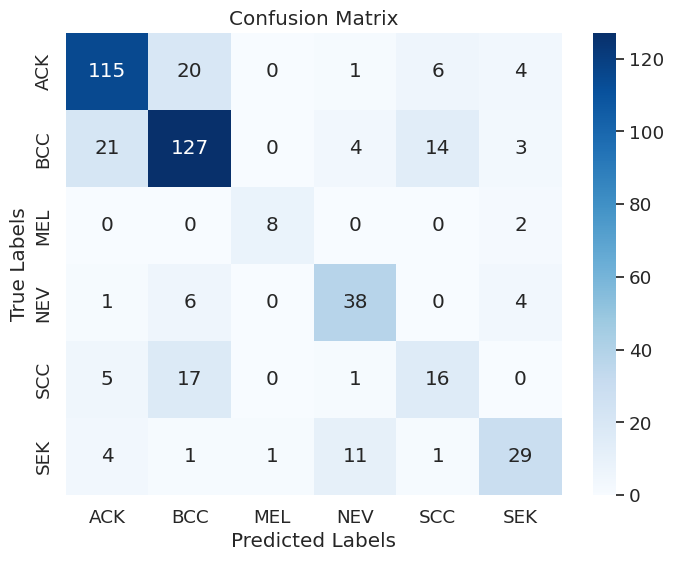


Overall Multiclass Testing Accuracy: 0.7239130434782609
Classification Report:
              precision    recall  f1-score     support
ACK            0.787671  0.787671  0.787671  146.000000
BCC            0.742690  0.751479  0.747059  169.000000
MEL            0.888889  0.800000  0.842105   10.000000
NEV            0.690909  0.775510  0.730769   49.000000
SCC            0.432432  0.410256  0.421053   39.000000
SEK            0.690476  0.617021  0.651685   47.000000
accuracy       0.723913  0.723913  0.723913    0.723913
macro avg      0.705511  0.690323  0.696724  460.000000
weighted avg   0.722990  0.723913  0.722896  460.000000

Overall Multiclass ROC AUC Score: 0.813922213715985


In [13]:
y_pred = model.predict(x_test)
print(y_pred)
y_pred_labels = np.argmax(y_pred, axis=1)

# Convert one-hot encoded actual classes to class labels
y_true_labels = np.argmax(y_test, axis=1)

# Convert class indices to class names for y_true and y_pred
y_true_labels_names = [label_to_dx_mapping[label] for label in y_true_labels]
y_pred_labels_names = [label_to_dx_mapping[label] for label in y_pred_labels]

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels_names, y_pred_labels_names)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(label_to_dx_mapping.values()),
            yticklabels=list(label_to_dx_mapping.values()))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Calculate accuracy
accuracy = np.mean(y_pred_labels == y_true_labels)
print("\nOverall Multiclass Testing Accuracy:", accuracy)
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

# Calculate Precision, Recall, F1-score, and Support
report = classification_report(y_true_labels_names, y_pred_labels_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Calculate AUC score
# Binarize the output
lb = LabelBinarizer()
lb.fit(y_true_labels_names)
y_test_bin = lb.transform(y_true_labels_names)
y_pred_bin = lb.transform(y_pred_labels_names)

roc_auc = roc_auc_score(y_test_bin, y_pred_bin, multi_class='ovr')

print("Classification Report:")
print(report_df)

print("\nOverall Multiclass ROC AUC Score:", roc_auc)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step


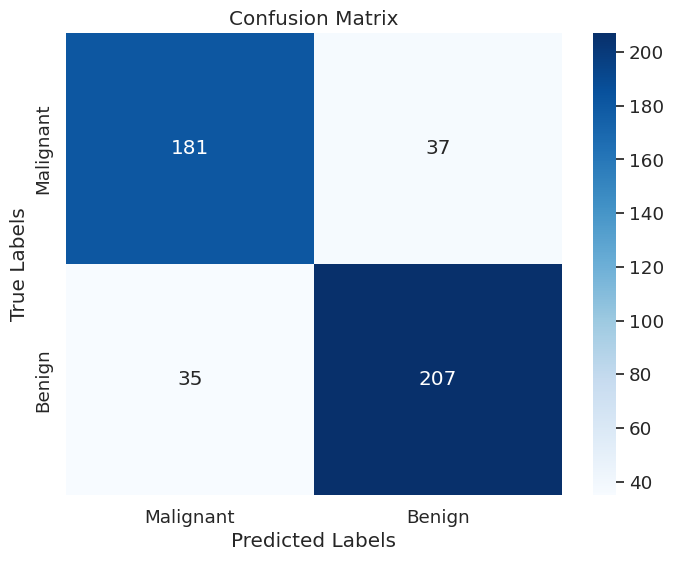


Overall Binary Class Testing Accuracy: 0.8434782608695652
Classification Report:
              precision    recall  f1-score     support
Malignant      0.837963  0.830275  0.834101  218.000000
Benign         0.848361  0.855372  0.851852  242.000000
accuracy       0.843478  0.843478  0.843478    0.843478
macro avg      0.843162  0.842824  0.842977  460.000000
weighted avg   0.843433  0.843478  0.843440  460.000000

Overall Binary Class ROC AUC Score: 0.8428235650921222


In [14]:
# Predict probabilities
y_pred = model.predict(x_test)

# Convert y_pred to the new binary format
y_new = np.zeros((y_pred.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_new[:, 0] = y_pred[:, 1] + y_pred[:, 2] + y_pred[:, 4]
y_new[:, 1] = y_pred[:, 0] + y_pred[:, 3] + y_pred[:, 5]

# Convert probabilities to class labels
y_pred_labels = np.argmax(y_new, axis=1)
# Convert one-hot encoded y_test to the new binary format
y_true_new = np.zeros((y_test.shape[0], 2))  # Initialize a new array of shape (n, 2)
y_true_new[:, 0] = y_test[:, 1] + y_test[:, 2] + y_test[:, 4]
y_true_new[:, 1] = y_test[:, 0] + y_test[:, 3] + y_test[:, 5]

# Convert probabilities to class labels
y_true_labels = np.argmax(y_true_new, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Malignant', 'Benign'],
            yticklabels=['Malignant', 'Benign'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Calculate accuracy
accuracy = np.mean(y_pred_labels == y_true_labels)
print("\nOverall Binary Class Testing Accuracy:", accuracy)
from sklearn.metrics import classification_report, roc_auc_score

# Calculate Precision, Recall, F1-score, and Support
report = classification_report(y_true_labels, y_pred_labels, target_names=['Malignant', 'Benign'], output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Calculate AUC score
roc_auc = roc_auc_score(y_true_labels, y_pred_labels)

print("Classification Report:")
print(report_df)

print("\nOverall Binary Class ROC AUC Score:", roc_auc)


In [15]:
x_train_out = np.asarray(train_df_meta['image'].tolist())
x_train_out = x_train_out/255.
print(x_train_out)

[[[[0.5254902  0.40392157 0.3254902 ]
   [0.52156863 0.4        0.32156863]
   [0.50196078 0.38431373 0.30588235]
   ...
   [0.4        0.29411765 0.21960784]
   [0.40392157 0.30588235 0.22745098]
   [0.39215686 0.29411765 0.21568627]]

  [[0.5254902  0.40392157 0.3254902 ]
   [0.50980392 0.38823529 0.30980392]
   [0.48235294 0.36078431 0.27843137]
   ...
   [0.39607843 0.29019608 0.21568627]
   [0.40784314 0.30588235 0.23137255]
   [0.40392157 0.30196078 0.22745098]]

  [[0.52941176 0.40784314 0.32941176]
   [0.49411765 0.37254902 0.29411765]
   [0.47843137 0.35686275 0.2745098 ]
   ...
   [0.39607843 0.29019608 0.22352941]
   [0.4        0.29803922 0.22745098]
   [0.40392157 0.30196078 0.23529412]]

  ...

  [[0.42745098 0.30588235 0.23529412]
   [0.44705882 0.3254902  0.25490196]
   [0.44705882 0.33333333 0.25098039]
   ...
   [0.31372549 0.21176471 0.1372549 ]
   [0.33333333 0.23529412 0.15686275]
   [0.33333333 0.23529412 0.15686275]]

  [[0.43921569 0.32156863 0.25098039]
   [0.4

In [16]:
import pandas as pd


# Assuming train_df_meta is your DataFrame and model is your trained model
# Run model prediction on your data to get probabilities for each class
probabilities = model.predict(x_train_out)

# Add probabilities to the DataFrame with new column names for each class
# Assuming your classes are ordered from 0 to 5 in the output of model.predict
for i in range(6):
    train_df_meta[f'class_{i}_prob'] = probabilities[:, i]

# Display the updated DataFrame
train_df_meta.head()

58/58 ━━━━━━━━━━━━━━━━━━━━ 17s 297ms/step


,smoke,drink,background_father,background_mother,age,pesticide,gender,skin_cancer_history,cancer_history,has_piped_water,...,bleed,elevation,biopsed,image,class_0_prob,class_1_prob,class_2_prob,class_3_prob,class_4_prob,class_5_prob
728,False,False,POMERANIA,POMERANIA,68,True,MALE,False,False,True,...,True,True,True,"[[[134, 103, 83], [133, 102, 82], [128, 98, 78...",0.999650,0.000041,0.000023,0.000201,0.000068,0.000017
1653,True,False,BRAZIL,PORTUGAL,53,True,MALE,True,True,True,...,False,False,False,"[[[76, 63, 48], [79, 66, 49], [83, 72, 53], [8...",0.998680,0.000321,0.000155,0.000393,0.000322,0.000129
2186,False,True,POMERANIA,POMERANIA,51,True,MALE,True,False,True,...,False,True,True,"[[[175, 154, 140], [174, 152, 135], [173, 151,...",0.000118,0.999392,0.000010,0.000016,0.000434,0.000030
127,True,False,BRAZIL,PORTUGAL,40,True,MALE,False,True,True,...,True,False,False,"[[[138, 97, 72], [138, 97, 72], [139, 95, 71],...",0.998916,0.000272,0.000132,0.000216,0.000277,0.000188
903,False,False,GERMANY,GERMANY,64,False,FEMALE,True,False,True,...,True,False,True,"[[[241, 175, 155], [239, 174, 153], [237, 173,...",0.000027,0.000046,0.000101,0.000108,0.000016,0.999702


In [17]:
# Drop the 'image' column from train_df_meta
train_df_meta = train_df_meta.drop(columns=['image'])

# Display the updated DataFrame to confirm
train_df_meta.head()


,smoke,drink,background_father,background_mother,age,pesticide,gender,skin_cancer_history,cancer_history,has_piped_water,...,changed,bleed,elevation,biopsed,class_0_prob,class_1_prob,class_2_prob,class_3_prob,class_4_prob,class_5_prob
728,False,False,POMERANIA,POMERANIA,68,True,MALE,False,False,True,...,False,True,True,True,0.999650,0.000041,0.000023,0.000201,0.000068,0.000017
1653,True,False,BRAZIL,PORTUGAL,53,True,MALE,True,True,True,...,False,False,False,False,0.998680,0.000321,0.000155,0.000393,0.000322,0.000129
2186,False,True,POMERANIA,POMERANIA,51,True,MALE,True,False,True,...,UNK,False,True,True,0.000118,0.999392,0.000010,0.000016,0.000434,0.000030
127,True,False,BRAZIL,PORTUGAL,40,True,MALE,False,True,True,...,False,True,False,False,0.998916,0.000272,0.000132,0.000216,0.000277,0.000188
903,False,False,GERMANY,GERMANY,64,False,FEMALE,True,False,True,...,False,True,False,True,0.000027,0.000046,0.000101,0.000108,0.000016,0.999702


In [18]:
# Save the DataFrame to CSV without the index
train_df_meta.to_csv("train_df_with_prob.csv", index=False)

In [19]:
x_train_out = np.asarray(test_df_meta['image'].tolist())
x_train_out = x_train_out/255.
print(x_train_out)

[[[[0.64313725 0.52156863 0.5372549 ]
   [0.64313725 0.52156863 0.5372549 ]
   [0.63137255 0.50980392 0.5254902 ]
   ...
   [0.75686275 0.6        0.60392157]
   [0.74901961 0.59607843 0.60784314]
   [0.77647059 0.63137255 0.64313725]]

  [[0.64705882 0.5254902  0.54117647]
   [0.62745098 0.50588235 0.52156863]
   [0.62352941 0.49803922 0.51764706]
   ...
   [0.75294118 0.59607843 0.60392157]
   [0.75294118 0.60392157 0.60784314]
   [0.75294118 0.60784314 0.61960784]]

  [[0.63137255 0.50980392 0.5254902 ]
   [0.63921569 0.51372549 0.53333333]
   [0.62745098 0.50588235 0.52156863]
   ...
   [0.74901961 0.59215686 0.6       ]
   [0.75294118 0.6        0.60784314]
   [0.75294118 0.60392157 0.61568627]]

  ...

  [[0.81176471 0.59607843 0.62352941]
   [0.82352941 0.60784314 0.62745098]
   [0.81568627 0.6        0.62352941]
   ...
   [0.59607843 0.48627451 0.54509804]
   [0.60784314 0.50588235 0.55686275]
   [0.61568627 0.50980392 0.56470588]]

  [[0.81960784 0.60392157 0.63137255]
   [0.8

In [20]:
import pandas as pd


# Assuming train_df_meta is your DataFrame and model is your trained model
# Run model prediction on your data to get probabilities for each class
probabilities = model.predict(x_train_out)

# Add probabilities to the DataFrame with new column names for each class
# Assuming your classes are ordered from 0 to 5 in the output of model.predict
for i in range(6):
    test_df_meta[f'class_{i}_prob'] = probabilities[:, i]

# Display the updated DataFrame
test_df_meta.head()

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step


,smoke,drink,background_father,background_mother,age,pesticide,gender,skin_cancer_history,cancer_history,has_piped_water,...,bleed,elevation,biopsed,image,class_0_prob,class_1_prob,class_2_prob,class_3_prob,class_4_prob,class_5_prob
11,False,False,POMERANIA,POMERANIA,34,True,FEMALE,True,False,False,...,True,True,True,"[[[164, 133, 137], [164, 133, 137], [161, 130,...",0.010365,0.002610,0.000941,0.000356,0.985130,0.000598
719,False,False,POMERANIA,POMERANIA,76,True,MALE,False,True,True,...,True,True,True,"[[[209, 169, 135], [212, 173, 139], [216, 174,...",0.001215,0.997493,0.000101,0.000426,0.000676,0.000090
305,True,False,BRAZIL,PORTUGAL,56,True,MALE,True,True,True,...,False,False,False,"[[[175, 76, 47], [177, 80, 51], [183, 87, 62],...",0.999059,0.000214,0.000072,0.000191,0.000188,0.000276
2034,False,False,AUSTRIA,POMERANIA,38,True,FEMALE,True,True,False,...,False,True,False,"[[[121, 113, 102], [120, 112, 101], [120, 112,...",0.000070,0.000458,0.000117,0.001217,0.000023,0.998115
2098,True,False,AUSTRIA,PORTUGAL,43,True,MALE,True,True,False,...,True,True,False,"[[[197, 187, 161], [197, 187, 161], [198, 186,...",0.999619,0.000112,0.000063,0.000074,0.000075,0.000057


In [21]:
# Drop the 'image' column from train_df_meta
test_df_meta = test_df_meta.drop(columns=['image'])

# Display the updated DataFrame to confirm
test_df_meta.head()


,smoke,drink,background_father,background_mother,age,pesticide,gender,skin_cancer_history,cancer_history,has_piped_water,...,changed,bleed,elevation,biopsed,class_0_prob,class_1_prob,class_2_prob,class_3_prob,class_4_prob,class_5_prob
11,False,False,POMERANIA,POMERANIA,34,True,FEMALE,True,False,False,...,UNK,True,True,True,0.010365,0.002610,0.000941,0.000356,0.985130,0.000598
719,False,False,POMERANIA,POMERANIA,76,True,MALE,False,True,True,...,False,True,True,True,0.001215,0.997493,0.000101,0.000426,0.000676,0.000090
305,True,False,BRAZIL,PORTUGAL,56,True,MALE,True,True,True,...,False,False,False,False,0.999059,0.000214,0.000072,0.000191,0.000188,0.000276
2034,False,False,AUSTRIA,POMERANIA,38,True,FEMALE,True,True,False,...,False,False,True,False,0.000070,0.000458,0.000117,0.001217,0.000023,0.998115
2098,True,False,AUSTRIA,PORTUGAL,43,True,MALE,True,True,False,...,False,True,True,False,0.999619,0.000112,0.000063,0.000074,0.000075,0.000057


In [22]:
# Save the DataFrame to CSV without the index
test_df_meta.to_csv("test_df_with_prob.csv", index=False)